In [604]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Worldometer Data

Data is from: https://www.worldometers.info/coronavirus/

I resorted to copying and pasting the data into an excel spreadsheet 'myfile.xlsx'.

In [605]:
df_cases = pd.read_excel (r'myfile.xlsx',sheet_name='cases')
df_deaths = pd.read_excel (r'myfile.xlsx',sheet_name='deaths')
df_test = pd.read_excel(r'myfile.xlsx',sheet_name='tests')

# Neatening the numpy arrays of data

Data is from table with regular titles at intervals, such as 'Date' repetition (for viewing purposes on wikipedia)

Had to remove this for ease of analysis.

In [606]:
def remove_annoying_rows(array):
    counter = 0
    ignore_rows=[0,1,2]
    while counter < np.shape(array)[0]:
        row = array[counter]
        is_row_string = False
        if counter in ignore_rows:
            pass
        else:
            if type(row[0]) == datetime:
                pass
            elif str(row[0])[0] == '2':
                    pass
            elif type(row[0]) == pd.Timestamp:
                pass
            else:
                is_row_string = True
            
            if is_row_string == True:
                array = np.delete(array, (counter), axis=0)
        counter +=1 
    
    return(array)
numpy_tables_cases = remove_annoying_rows(pd.DataFrame.to_numpy(df_cases,dtype='object'))
numpy_tables_deaths = remove_annoying_rows(pd.DataFrame.to_numpy(df_deaths,dtype='object'))
print(numpy_tables_cases)

[['(local)' 'Argentina' 'Chile' ... 'Russia' 'ignore' 'International']
 [nan nan nan ... nan nan nan]
 ['20.1.10' nan nan ... nan 0 nan]
 ...
 ['20.4.04' nan nan ... nan nan 84810]
 ['20.4.05' nan nan ... nan nan 71409]
 ['20.4.06' nan nan ... nan nan 73142]]


# Create dictionaries for datasets 

to help with indexing down the line

In [607]:
def create_dictionaryOf_indexes(data):
    dictionary = {}
    for i,country in enumerate(data[0]):
        if country == '(local)':
            pass
        elif country == 'New that day' or country == 'Sum to date':
            pass
        else:
            dictionary[str(country)] = i
    return(dictionary)

dictionary_cases_index = create_dictionaryOf_indexes(numpy_tables_cases)
dictionary_deaths_index = create_dictionaryOf_indexes(numpy_tables_deaths)

In [608]:
#create a list of problamatic countries whose names are not the same on the cases spreadsheet and deaths spreadsheet
#Extra care must be taken when analysing these countries
problomatic_countries = []
list_countries_cases = []
list_countries_deaths = []

for country in (numpy_tables_cases[0]): list_countries_cases.append(country)
for country in numpy_tables_deaths[0]: 
    list_countries_deaths.append(country)
    if country not in list_countries_cases:
        problomatic_countries.append(country)

for country in numpy_tables_cases[0]: 
    if country not in list_countries_deaths:
        problomatic_countries.append(country)



In [609]:
trendline_colour_dictionary = {}
data_colour_dictionary = {}

trendline_colour_dictionary['UK'],trendline_colour_dictionary['Italy'],trendline_colour_dictionary['Spain']='r','g','y'
trendline_colour_dictionary['United States'],trendline_colour_dictionary['Sweden']='b','y'

data_colour_dictionary['UK'],data_colour_dictionary['Italy'],data_colour_dictionary['Spain']='tomato','lime','khaki'
data_colour_dictionary['United States'],data_colour_dictionary['Sweden']='deepskyblue','yellow'

# Population of Countries

In [610]:
import requests
import lxml.html as lh
import pandas as pd

url='https://www.worldometers.info/world-population/population-by-country/'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

#create dictionary for country:population
population_dictionary = {}

for T in tr_elements[1:]: population_dictionary[T[1].text_content()] = int(T[2].text_content().replace(',', '')) 
population_dictionary['International'] =  7775500000
population_dictionary['UK'] = population_dictionary.get('United Kingdom')
# population_dictionary

ConnectionError: HTTPSConnectionPool(host='www.worldometers.info', port=443): Max retries exceeded with url: /world-population/population-by-country/ (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x0000018BA02B20F0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

# Producing cumulative data


In [611]:
def produce_cumulative_data(array):
    '''produce numpy array with structure:
            date1 date2 date3 date4 date5 ... dateToday
    country1: 0     0     1     2     5
    country2: 0     1     7     19    60  etc.
    country3:
    ...
    countryN
    '''
    
    
    index_length = np.shape(array)[1]
    previous_cases = np.zeros(shape = (np.shape(array)[1]),dtype=int)
    dates_ = np.zeros(shape=(1,np.shape(array)[0]),dtype = 'object')
    yvals_ = np.zeros(shape=(np.shape(array)),dtype = 'object').T
    

    for i,date_point in enumerate(array):
        if type(date_point[0]) != float:
            if date_point[0][0] == '2':
                for letter in range(len(date_point[0])):
                    if date_point[0][letter] == '.': 
                        date_point[0] = date_point[0][:letter]+'-'+date_point[0][letter+1:]
                for letter in range(1,len(date_point[0])-1):
                    if date_point[0][letter-1] == '-' and date_point[0][letter+1] == '-':
                        date_point[0] = date_point[0][:letter] + '0' + date_point[0][letter:]

                date = datetime.strptime(date_point[0], '%y-%m-%d')
                number_cases = np.zeros((len(array[0])))
                for j in range(index_length):
                    if type(date_point[j]) == int:
                        if type(previous_cases[i]) == np.int32:
                            number_cases[j] = int(date_point[j] + previous_cases[j])
                            previous_cases[j] = int(number_cases[j])

                        elif previous_cases[j] == 0:
                            number_cases[j] = date_point[j]
                            previous_cases[j] = int(number_cases[j])
                    else:
                        number_cases[j] = previous_cases[j]
                    yvals_[j][i] = number_cases[j]                                            
                dates_[0][i] = date 
    dates_ = dates_[0]
    
    columns_to_be_deleted = []
    for j,day in enumerate(dates_):
        if day == 0:
            columns_to_be_deleted.append(j)

    dates_ = np.delete(dates_,columns_to_be_deleted,0)
    yvals_ = np.delete(yvals_,columns_to_be_deleted,1)
    print('date range :', dates_[0],'to: ',dates_[-1])

    
    return(dates_,yvals_)
                
dates_cases,yvals_cases = produce_cumulative_data(numpy_tables_cases)
dates_deaths,yvals_deaths = produce_cumulative_data(numpy_tables_deaths)




date range : 2020-01-10 00:00:00 to:  2020-04-06 00:00:00
date range : 2020-01-21 00:00:00 to:  2020-04-06 00:00:00


# Fatality rate data for ROW

In [612]:
def find_index_forDate(date_to_be_indexed,cases_or_deaths):
    '''finds index for given date'''
    
    if cases_or_deaths == 'cases':
        for i,date in enumerate(dates_cases):
            if date == date_to_be_indexed:
                return(i)
    elif cases_or_deaths == 'deaths':
        for i,date in enumerate(dates_deaths):
            if date == date_to_be_indexed:
                return(i)
            

def find_countryName_fromIndex(index,cases_or_deaths):
    if cases_or_deaths == 'cases':
        for country_name in dictionary_cases_index:
            if dictionary_cases_index.get(country_name) == index:
                return(country_name)
    elif cases_or_deaths == 'deaths':
        for country_name in dictionary_deaths_index:
            if dictionary_deaths_index.get(country_name) == index:
                return(country_name)

        
def produce_fatality_rate(percentage = True):
    '''creates array with same dimensions as deaths array'''
    fatality_rates = np.zeros(shape=(np.shape(yvals_deaths)),dtype = float)
    
    
    for i,country in enumerate(yvals_deaths):
        if find_countryName_fromIndex(i,'deaths') is not None:
            country_string = find_countryName_fromIndex(i,'deaths')
            if country_string in dictionary_deaths_index and country_string in dictionary_cases_index:
                index_for_casesArray = dictionary_cases_index.get(country_string)
                for j,date in enumerate(dates_deaths):
                    index_fordate_inCases = find_index_forDate(date,'cases') #probably couldve done this earlier on to prevent it being done everytime this function iterates for each country
                    if yvals_cases[index_for_casesArray,index_fordate_inCases] != 0:
                        fatality_rates[i,j] = 100*yvals_deaths[i,j]/yvals_cases[index_for_casesArray,index_fordate_inCases]
    return(fatality_rates)          

yvals_fatality_rates = produce_fatality_rate()

# Differentiation algorithm

In [613]:
def differentiate(yvalues,time_periodInDays=1):
    yvals = np.zeros(shape=(np.shape(yvalues)),dtype = float)
    for i,country in enumerate(yvalues):
        for j,value_on_date in enumerate(country):
            if j != 0:   
                yvals[i,j] = (yvalues[i,j] - yvalues[i,j-1])/time_periodInDays
    return(yvals)

# Exponential algorithm

In [614]:
def exponential(yvalues):
    yvals = np.zeros(shape=(np.shape(yvalues)),dtype = float)
    for i,country in enumerate(yvalues):
        for j,value_on_date in enumerate(country):
            if j!= 0:
                yvals[i,j] = (yvalues[i,j] - yvalues[i,j-1])/yvalues[i,j]
    return(yvals)

# Divide all values by population algorithm

In [615]:
def divide_by_population(yvalues,cases_or_deaths):
    index_dictionary = {}
    if cases_or_deaths == 'cases': index_dictionary = dictionary_cases_index
    elif cases_or_deaths == 'deaths': index_dictionary = dictionary_deaths_index
    new_yvalues = np.zeros(shape=(np.shape(yvalues)),dtype = float)
        
    for index,country in enumerate(yvalues):
        new_yvalues[index] = country
        population = 0
        country_name = find_countryName_fromIndex(index,cases_or_deaths)
        if country_name and country_name not in problomatic_countries:
            population = population_dictionary[find_countryName_fromIndex(index,cases_or_deaths)]
            new_yvalues[index] /= population
    
    return(new_yvalues)



# Trendline algorithm

In [616]:
def polyreg(yvalues, k):
    # The function should return the the coefficient vector beta, the fit, and the vector of residuals
#     print(yvalues)
    all_ones = np.ones(np.shape(yvalues))
    if k == 0:
        A = np.vstack((np.ones(np.shape(yvalues)), yvalues)).T
        beta_point = np.linalg.lstsq(A, yvalues, rcond=None)[0][0] #finds mean point
        array_of_point = np.transpose(np.ones(np.shape(yvalues))*beta_point)
        fit_0 = np.mean(yvalues)*all_ones
        resid_point = yvalues - fit_0
        return(beta_point,fit_0,resid_point)
    
    elif k>=0:
        for i in range(k+1):
            if i == 0:
                A_T = ([np.ones(np.shape(yvalues))])
            else:
                A_T = np.vstack((A_T,yvalues**i))
        A = np.transpose(A_T)  
        beta_polynomial = np.linalg.lstsq(A, yvalues, rcond=None)[0]
        fit_polynomial = A.dot(beta_polynomial)
        resid_polynomial = yvalues - fit_polynomial
#         print(beta_polynomial,fit_polynomial,resid_polynomial)
        return(beta_polynomial,fit_polynomial,resid_polynomial)


# Plotting the data

In [643]:
import matplotlib as lib
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import matplotlib.style
import warnings
warnings.simplefilter('ignore',RuntimeWarning)
style = 'seaborn'
list_inputs = ['cumulative','new','acceleration','exponential','fatality rate']


def plot(type_of_plot,countries_list,cases_or_deaths,date_min_index=0,
         annotation = None,date_max_index=None,timeshift=None,title='auto',
         trendline=False,divideBy_population=False,style=style):
    '''Different types of plot are: cumulative, new, acceleration,exponential,fatality rate.  
    timeshift is in days and always applies to UK'''
    
    ##### checks #####
    assert(type(countries_list) == list)
    assert(type_of_plot in list_inputs), 'type_of_plot = ' + str(type_of_plot) + 'is not in ' + list_inputs
    if divideBy_population == True:
        assert(type_of_plot != 'exponential' and type_of_plot != 'fatality rate'), 'doesnt make sense to divide by population for plot of: '+type_of_plot
    for country in countries_list:
        if type_of_plot == 'fatality rate': assert(country not in problomatic_countries), 'The country ' + str(country) + 'is problomatic'
        if cases_or_deaths =='cases':
            assert(country in dictionary_cases_index), str(country) + ' is not in ' + str(dictionary_cases_index)
        elif cases_or_deaths == 'deaths':
            assert(country in dictionary_deaths_index), str(country) + ' is not in ' + str(dictionary_deaths_index)
    if type_of_plot == 'fatality rate': assert(cases_or_deaths == None), 'Fatality rate requires argument "cases_or_deaths_" = None, but currently inputed as: ' + str(cases_or_deaths)
    ##### checks #####

    ##### setup stuff #####
    with plt.style.context(style):
        fig, ax = plt.subplots(num=style)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True)
    ##### setup stuff #####
    
    ###### title stuff #####
    end_title = ''
    if timeshift:
        end_title += ' with UK shifted back by ' +str(timeshift) + 'days'
    if divideBy_population == True:
        end_title += ' divided by population'
        ax.set_ylabel('percentage of population')  
    str_cases_or_deaths = str(cases_or_deaths)
    if cases_or_deaths == None: str_cases_or_deaths = ''
    auto_title = str(type_of_plot)+' '+str_cases_or_deaths+end_title
    if title == 'auto':
        ax.title.set_text(auto_title)
    else:
        ax.title.set_text(str(title))
        print('auto title would be:'+ auto_title)
    ##### title stuff #####
    
    ##### axis stuff  #####
    if type_of_plot  == 'fatality rate':
        ax.set_ylabel('percentage deaths/cases')
    elif type_of_plot == 'new':
        if divide_by_population == True:
            ax.set_ylabel('percentage cases/population')
    elif type_of_plot == 'exponential':
        ax.set_ylabel('Time Constant')
    elif divideBy_population == True:
        ax.set_ylabel('percentage of population')
    ###### axis stuff #####    
    
    ##### define dates and yvals #####
    if cases_or_deaths == 'cases':
        dates,yvals = dates_cases,yvals_cases
    elif cases_or_deaths == 'deaths':
        dates,yvals = dates_deaths,yvals_deaths
    else:
        dates,yvals = dates_deaths,yvals_fatality_rates
        print('***yvalues used are of fatality rate***')
    
    if type_of_plot == 'new':
        yvals = differentiate(yvals)
    elif type_of_plot == 'acceleration':
        yvals = differentiate(differentiate(yvals))
    elif type_of_plot == 'exponential':
        yvals = exponential(yvals)
    ##### define dates and yvals ######
        
        
    ##### timeshift function #####
    if timeshift is not None:
        assert(type(timeshift) == int), 'timeshift needs to be in integers of days, current timeshift is '+ str(timeshift) + ' and type: ' + str(type(timeshift))
        altered_dates_uk = []
        for date in dates:
            altered_dates_uk.append(np.datetime64(date)-np.timedelta64(timeshift, 'D'))
    ##### timeshift function #####
    
    ##### divide by population function #####
    if divideBy_population == True: 
        yvals = 100*divide_by_population(yvals,cases_or_deaths)
    ##### divide by population function #####
    
    ##### date range #####
    dates,yvals = dates[date_min_index:date_max_index],[yvals[i][date_min_index:date_max_index] for i in range(np.shape(yvals)[0])] 
    ##### date range #####
    
    ##### plotting time #####
    for country in countries_list:    
        if cases_or_deaths == 'cases':
            dictionary=dictionary_cases_index
        elif cases_or_deaths =='deaths' or type_of_plot == 'fatality rate':
            dictionary=dictionary_deaths_index
        
        if country =='UK' and timeshift is not None:
            ax.plot(altered_dates_uk,yvals[dictionary.get('UK')],label = ' Shifted UK',color = 'tomato')
        else:
            ax.plot(dates,yvals[dictionary.get(country)],label = country, color = data_colour_dictionary.get(country))
    ##### plotting time #####
    
    ##### add trendlines #####
    if trendline == True:
        degree = 50
        cutoff_index = -1
        dates_ = dates[:cutoff_index]
        x = mdates.date2num(dates)
        for country in countries_list:
            z0 = np.polyfit(x, yvals[dictionary.get(country)], degree)
            p0 = np.poly1d(z0)
            ax.plot(dates_, p0(x[:cutoff_index]),color = trendline_colour_dictionary.get(country))
    ##### add trendlines #####
    
    ##### setup the axis and annotation ##### 
    datemin,datemax = np.datetime64(dates[0], 'D'),np.datetime64(dates[-1], 'D')
    ax.set_xlim(datemin, datemax)
    ax.legend(loc='best')
    if annotation is not None:
        ax.annotate('Test', (mdates.date2num(dates[1]), yvals[1]), xytext=(mdates.date2num(dates[1]),yvals[1]), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    ##### setup the axis and annotation #####
    
    ##### output #####
    fig.savefig('plots/' + str(type_of_plot) + str(cases_or_deaths) + str(countries_list) + 'timeshift='+str(timeshift)+'divide_by_population='+str(divideBy_population)+'.png',dpi=100)
    plt.show()
    ##### output #####
    
    
    fig.clf() # a precautionary cleanup
    


In [644]:
def plot_bar(data_tests,top_x=10):
    
    df_test = data_tests[:top_x]
    x = np.arange(len(df_test['Country,Other']))  # the label locations
    width = 0.35
        
    with plt.style.context(style):
        fig, ax = plt.subplots(num=style)
    rects1 = ax.bar(x - width/2, df_test['Tests_per1Mpop'], width, label='Tests per 1M pop')
    rects2 = ax.bar(x + width/2, df_test['TotalDeaths_per1Mpop'], width, label='Deaths per 1M pop')


    ax.set_title('Tests and Deaths per 1M people in population')
    ax.set_xticks(x)
    ax.set_xticklabels(df_test['Country,Other'],rotation=45)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    fig.savefig('plots/'+'bar_plot'+'.png',dpi=100)
    plt.show()
    


# Today's Plots:

auto title would be:new cases divided by population


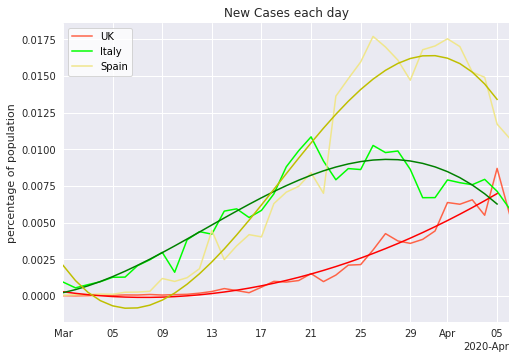

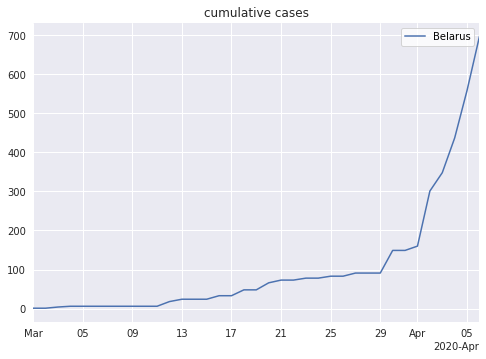

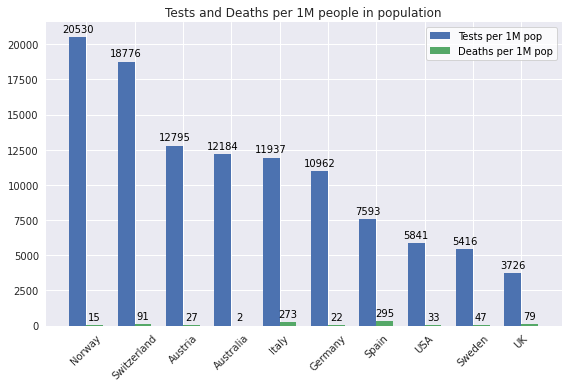

***yvalues used are of fatality rate***


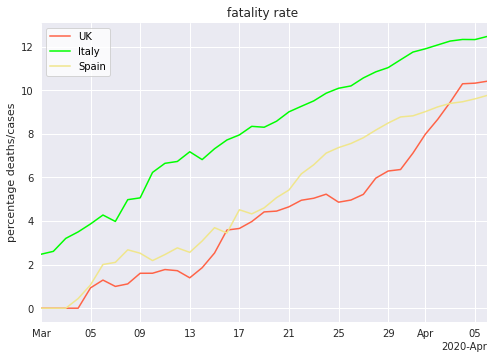

In [647]:
plot('new',['UK','Italy','Spain'],'cases',date_min_index=-37,trendline=True,divideBy_population=True,title='New Cases each day')
plot('cumulative',['Belarus'],'cases',date_min_index=-37,title='auto')#annotation='point where ')
plot_bar(df_test)
plot('fatality rate',['UK','Italy','Spain'],cases_or_deaths=None,date_min_index=-37,title='auto')


# My First Theory after looking at the data

The above chart seems to show a trend that every day, the number of new cases,N ~ 30% (R) of total cases over 10 days previously.

\begin{equation*}
    N(X) = \left(R \sum_{x=-10}^{0}N(x) \right) 
\end{equation*}
where k is in days

In [ ]:
yvals_governement_effect[uk_index][45:]

In [ ]:
#start from first value:
R = np.mean(yvals_governement_effect[uk_index][47:])/100
print(R)

In [ ]:
predictions = np.zeros(shape =(14,2),dtype='object')

for i,row in enumerate(predictions):
    row[0] = np.datetime64(dates[-10], 'D') + np.timedelta64(i, 'D')
    row[1] = yvals_[uk_index][-10+i] 
    if i == 10:
        row[1] += R*(yvals_[uk_index][-1]- yvals_[uk_index][-10]) + predictions[i-1][1]
    elif i > 10:
        row[1] += R*(predictions[i-1][1] - yvals_[uk_index][i-20]) + predictions[i-1][1]


predictions